## Face and Facial Keypoint detection

After we've trained a neural network to detect facial keypoints, we can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, we'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that our net expects. This step will be similar to the `data_transform` we created and applied in Notebook 2, whose job was to rescale, normalize, and turn any image into a Tensor to be accepted as input to our CNN.
3. Use our trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; we will select an image of faces in the `images/` directory.

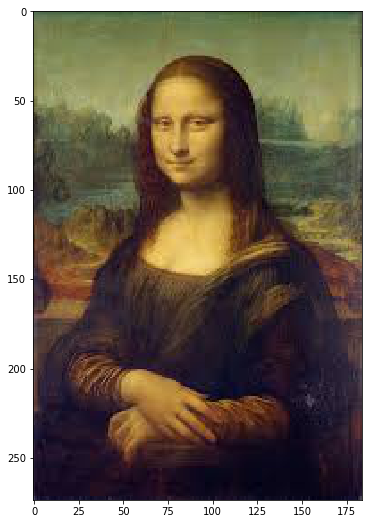

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/mona_lisa.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, we'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in our selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). We can optionally [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html).

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


Number of faces detected 1


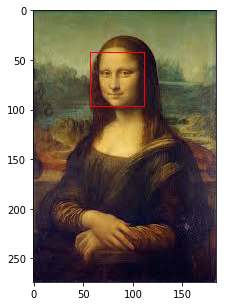

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until we successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 7)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

print ("Number of faces detected", len(faces))
# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # we may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0)) 

fig = plt.figure(figsize=(5,5))

plt.imshow(image_with_detections)

## Loading in a trained model

Now we will load our best model by its filename.

In [4]:
import torch
from models import Net

net = Net()

# load the best saved model parameters
net.load_state_dict(torch.load('saved_models/my_model_save_best.pt'))

# print out our net and prepare it for testing
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2)
  (dropout2): Dropout(p=0.3)
  (dropout3): Dropout(p=0.4)
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)

## Keypoint detection

We'll loop over each detected face in an image (again!) only this time, we'll transform those faces in Tensors that our CNN can accept as input images. There are two steps:

### Step  1: Transform each detected face into an input Tensor

1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for our CNN (224x224)
4. Reshape the numpy image into a torch image.


### Step 2: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for our network to see as input, we'll wrap that Tensor in a Variable() and can apply our `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display. We should end up with an image with facial keypoints that closely match the facial features on each individual face.

(-0.5, 183.5, 273.5, -0.5)

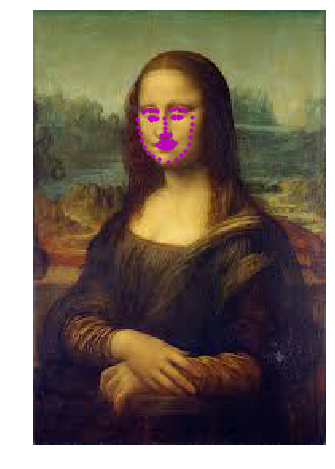

In [5]:
from torch.autograd import Variable

image_copy = np.copy(image)
plt.figure(figsize=(8,8))

# Loop over the detected faces
for (x,y,w,h) in faces:
    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]
    # Save the original shape that we will later use to undo the rescaling of keypoints
    orig_shape_crop = roi.shape
    
    # Perform the necessary transform steps
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    roi =  roi/255.0
    roi = cv2.resize(roi, (224, 224))
    if(len(roi.shape) == 2):
        # add that third color dim
        roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    roi = roi.transpose((2, 0, 1))
    roi = torch.from_numpy(roi)
    roi = Variable(roi)
    roi = roi.type(torch.FloatTensor)
    input_roi = roi.view(-1, roi.size()[0], roi.size()[1], roi.size()[2])
    
    # Perform a forward pass to get the predicted facial keypoints
    output_pts = net(input_roi)
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    
    # Uncomment following code, which un-transform the roi, if we want to plot the keypoints 
    # on roi and not original image
    #roi = roi.data
    #roi = roi.numpy()
    #roi = np.transpose(roi, (1, 2, 0))   # transpose to go from torch to numpy image

    # Un-transform the predicted keypoints
    output_pts = output_pts.data
    output_pts = output_pts.numpy()
    output_pts = np.squeeze(output_pts)
    
    # Undo the normalization and rescaling of keypoints, and align them with the faces
    x_values = ((output_pts[:, 0] * 50 + 100) * orig_shape_crop[1]/224) + x
    y_values = ((output_pts[:, 1] * 50 + 100) * orig_shape_crop[0]/224) + y
    
    # Display the corresponding keypoints for each face
    plt.scatter(x_values, y_values, marker='o', c='m', s=10)
plt.imshow(image_copy)
plt.axis('off')
